# 03 MissForest Imputation

The principle of MissForest imputator is shown in the following picture. Missing values are marked as values to 'predict' correspond to test set and all the rest constitute the training set. A random forest estimator is used to predict the missing values.

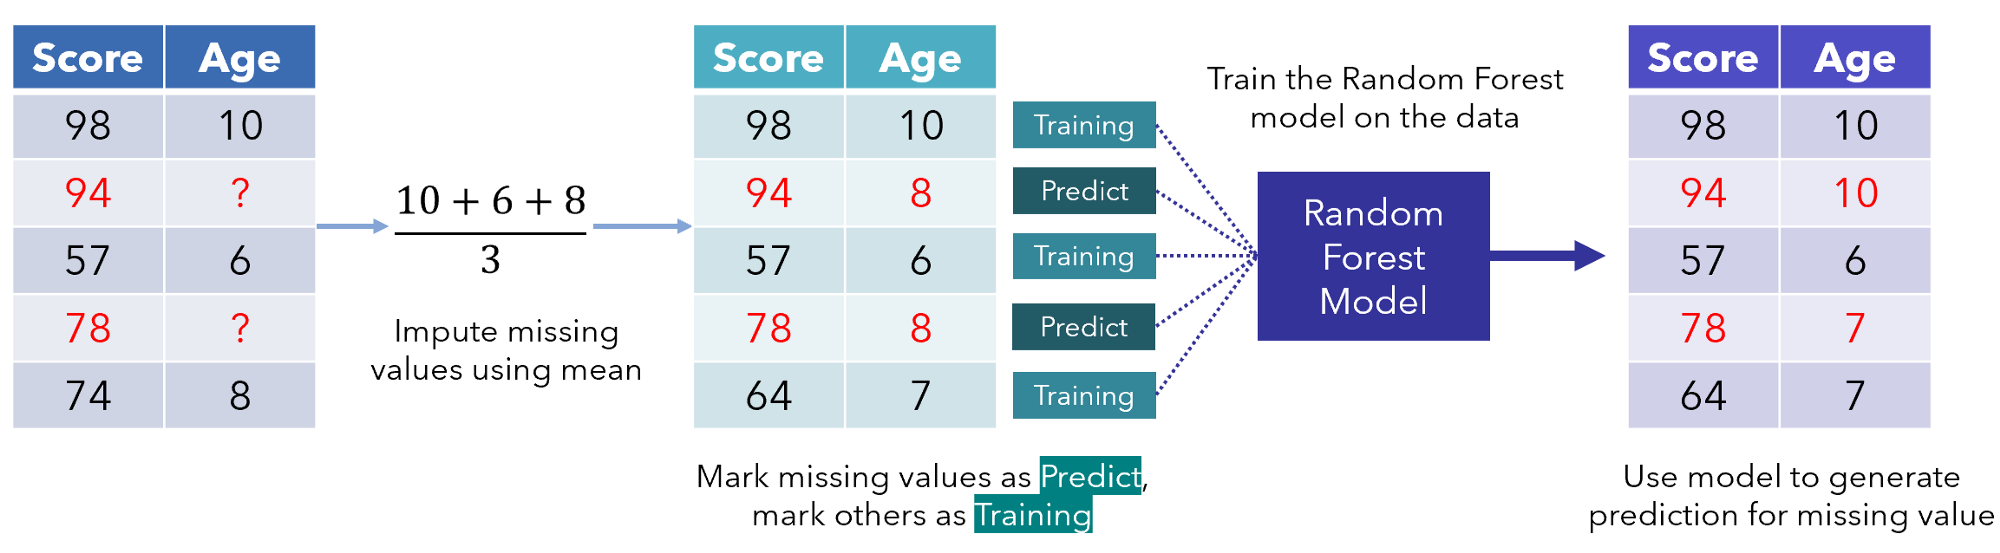

In [2]:
from IPython.display import Image
Image('img/MissForest_algorithm.png')

I read the splitted data and then I will impute the missing values of categoricalnominal variable wd (wind direction).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from datetime import datetime
import seaborn as sns
from pandas import Grouper
from missingpy import MissForest

from pandas.plotting import register_matplotlib_converters
from missingpy import MissForest

In [2]:
data_tr = pd.read_pickle('training_dataset_df.csv')
data_te = pd.read_pickle('test_dataset_df.csv')
data = pd.read_pickle('tidy_dataframe_capstone.csv')

In [3]:
data.shape

(35048, 28)

In [4]:
data_tr.shape

(30704, 28)

In [5]:
data_te.shape

(4344, 28)

In [6]:
data_tr.head(3)

,Weekday,Season,Year,Month,Day,Hour,SO2,NO2,CO,O3,...,it_rained,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5,Lag-6,Lag-7,Lag-8,EMA
Date and Time,,,,,,,,,,,,,,,,,,,,,
2013-03-01 16:00:00,Friday,winter,2013,3,1,16,7.0,9.0,300.0,72.0,...,0,12.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.925471
2013-03-01 17:00:00,Friday,winter,2013,3,1,17,8.0,14.0,300.0,67.0,...,0,11.0,12.0,3.0,3.0,3.0,3.0,3.0,3.0,5.753260
2013-03-01 18:00:00,Friday,winter,2013,3,1,18,9.0,20.0,400.0,58.0,...,0,13.0,11.0,12.0,3.0,3.0,3.0,3.0,3.0,6.150140


In [7]:
data_te.head(3)

,Weekday,Season,Year,Month,Day,Hour,SO2,NO2,CO,O3,...,it_rained,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5,Lag-6,Lag-7,Lag-8,EMA
Date and Time,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:00:00,Thursday,summer,2016,9,1,0,2.0,36.0,300.0,36.0,...,0,6.0,6.0,13.0,12.0,12.0,11.0,8.0,4.0,35.541733
2016-09-01 01:00:00,Thursday,summer,2016,9,1,1,2.0,36.0,300.0,28.0,...,0,12.0,6.0,6.0,13.0,12.0,12.0,11.0,8.0,35.439008
2016-09-01 02:00:00,Thursday,summer,2016,9,1,2,2.0,33.0,300.0,28.0,...,0,17.0,12.0,6.0,6.0,13.0,12.0,12.0,11.0,35.259291


In [8]:
data_tr.columns

Index(['Weekday', 'Season', 'Year', 'Month', 'Day', 'Hour', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'PM10', 'PM2.5',
       'it_rained', 'Lag-1', 'Lag-2', 'Lag-3', 'Lag-4', 'Lag-5', 'Lag-6',
       'Lag-7', 'Lag-8', 'EMA'],
      dtype='object')

df will be the dataframe for the imputation. I will not use all the columns for the imputation.

## Missing value imputation with missForest algorithm

there are 79 missing values in the nominal categorical feature wd (wind direction). I will therefore use the missForest algorithm to impute the missing values because of its simplicity and its robustness to noisy data and multicollinearity, since random-forests have built-in feature selection (evaluating entropy and information gain). it also outperforms KNN imputer. Furthermore no preprocessing steps are required like scaling or normalization.

I will impute the wd (wind direction) missing values which is a categorical nominal feature using the numerical features of data dataframe. I will use the dummy_na parameter set to True, otherwise the missing values will be replaced by zero. With dummy_na = True we have a new column wd_nan with 1s where we had missing values.

In [9]:
data.wd.isna().sum()

79

there are 13 missing values in the training dataset and 66 in the test dataset.

In [10]:
data_tr.wd.isna().sum()

13

In [11]:
data_te.wd.isna().sum()

66

In [12]:
data_te.shape

(4344, 28)

I will use the numerical features that correspond to the weather and the pollutants data as well as the target variable for the imputation. Therefore I will use the following subset of numerical features for the imputation:

In [13]:
subset = ['Year', 'Month', 'Day', 'Hour', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'PM10', 'PM2.5', 'wd']

In [14]:
df_tr = data_tr[subset]
df_te = data_te[subset]
df_tr.head(3)

,Year,Month,Day,Hour,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,PM10,PM2.5,wd
Date and Time,,,,,,,,,,,,,,,
2013-03-01 16:00:00,2013,3,1,16,7.0,9.0,300.0,72.0,5.9,1024.7,-18.8,3.3,17.0,11.0,N
2013-03-01 17:00:00,2013,3,1,17,8.0,14.0,300.0,67.0,5.3,1025.3,-19.3,2.0,18.0,13.0,NNW
2013-03-01 18:00:00,2013,3,1,18,9.0,20.0,400.0,58.0,4.1,1026.4,-19.5,2.2,18.0,10.0,NNE


In [15]:
df_te.head(3)

,Year,Month,Day,Hour,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,PM10,PM2.5,wd
Date and Time,,,,,,,,,,,,,,,
2016-09-01 00:00:00,2016,9,1,0,2.0,36.0,300.0,36.0,26.9,991.2,-1.1,1.5,31.0,12.0,WNW
2016-09-01 01:00:00,2016,9,1,1,2.0,36.0,300.0,28.0,26.6,991.1,-2.2,2.3,25.0,17.0,NW
2016-09-01 02:00:00,2016,9,1,2,2.0,33.0,300.0,28.0,26.5,990.6,-1.4,2.3,34.0,3.0,NW


In [16]:
cat_variables_tr = df_tr['wd']
cat_variables_te = df_te['wd']

I will now do the One-Hot-Encoding (OHE) for the 'wd' feature.

In [17]:
wd_dummies_tr = pd.get_dummies(cat_variables_tr, prefix = 'wd', dummy_na = True, 
                columns = ['ENE','ESE','N','NE','NNE','NNW','NW','S','SE','SSE','SSW','SW','W','WNW','WSW','wd_nan'], drop_first=True)
wd_dummies_tr.head()

,wd_ENE,wd_ESE,wd_N,wd_NE,wd_NNE,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW,wd_nan
Date and Time,,,,,,,,,,,,,,,,
2013-03-01 16:00:00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01 17:00:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-03-01 18:00:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-03-01 19:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01 20:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
wd_dummies_te = pd.get_dummies(cat_variables_te, prefix = 'wd', dummy_na = True, 
                columns = ['ENE','ESE','N','NE','NNE','NNW','NW','S','SE','SSE','SSW','SW','W','WNW','WSW','wd_nan'], drop_first=True)
wd_dummies_te.head()

,wd_ENE,wd_ESE,wd_N,wd_NE,wd_NNE,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW,wd_nan
Date and Time,,,,,,,,,,,,,,,,
2016-09-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2016-09-01 01:00:00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2016-09-01 02:00:00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2016-09-01 03:00:00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2016-09-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [19]:
wd_dummies_tr.columns

Index(['wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW',
       'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW', 'wd_nan'],
      dtype='object')

with the dummy_na = True we get an additional columns which we could use in order to set the NAs (np.na) values for the wd categorial variable. That means when wd_nan is 1 that indicates a missing value in the wd variable and all the possible values of wd - 'ENE','ESE','N','NE','NNE','NNW','NW','S','SE','SSE','SSW','SW','W','WNW','WSW' - should be set to np.nan as we do not which is the values of wd. Once we are done with this, we drop the column wd_nan as we do not need it any more.

In [20]:
# df1.loc[df1.v1_nan == 1, ["v1_A", "v1_B"]] = np.nan, del df1["v1_nan"]

wd_dummies_tr.loc[wd_dummies_tr['wd_nan'] == 1, ['wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW',
       'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW']] = np.nan
wd_dummies_tr.drop(['wd_nan'], axis = 1, inplace = True)

I perform the same processing fo the test dataset.

In [21]:
wd_dummies_te.loc[wd_dummies_te['wd_nan'] == 1, ['wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW',
       'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW',
       'wd_WSW']] = np.nan
wd_dummies_te.drop(['wd_nan'], axis = 1, inplace = True)

I check the missing values. 

In [22]:
data_tr.wd.isna().sum()

13

There should be 13 missing values per column.

In [23]:
wd_dummies_tr.isna().sum()

wd_ENE    13
wd_ESE    13
wd_N      13
wd_NE     13
wd_NNE    13
wd_NNW    13
wd_NW     13
wd_S      13
wd_SE     13
wd_SSE    13
wd_SSW    13
wd_SW     13
wd_W      13
wd_WNW    13
wd_WSW    13
dtype: int64

Likewise for the test subset

In [24]:
data_te.wd.isna().sum()

66

In [25]:
wd_dummies_te.isna().sum()

wd_ENE    66
wd_ESE    66
wd_N      66
wd_NE     66
wd_NNE    66
wd_NNW    66
wd_NW     66
wd_S      66
wd_SE     66
wd_SSE    66
wd_SSW    66
wd_SW     66
wd_W      66
wd_WNW    66
wd_WSW    66
dtype: int64

In [26]:
df_tr_tb_imp = pd.concat([df_tr, wd_dummies_tr], axis=1)
df_tr_tb_imp.columns

Index(['Year', 'Month', 'Day', 'Hour', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'WSPM', 'PM10', 'PM2.5', 'wd', 'wd_ENE', 'wd_ESE',
       'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE',
       'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW'],
      dtype='object')

In [27]:
df_te_tb_imp = pd.concat([df_te, wd_dummies_te], axis=1)
df_te_tb_imp.columns

Index(['Year', 'Month', 'Day', 'Hour', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'WSPM', 'PM10', 'PM2.5', 'wd', 'wd_ENE', 'wd_ESE',
       'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE',
       'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW'],
      dtype='object')

In [28]:
df_tr_tb_imp.drop(['wd'], axis = 1, inplace = True)
df_te_tb_imp.drop(['wd'], axis = 1, inplace = True)

In [29]:
df_tr_tb_imp.columns

Index(['Year', 'Month', 'Day', 'Hour', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'WSPM', 'PM10', 'PM2.5', 'wd_ENE', 'wd_ESE', 'wd_N',
       'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE',
       'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW'],
      dtype='object')

In [30]:
df_te_tb_imp.columns

Index(['Year', 'Month', 'Day', 'Hour', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'WSPM', 'PM10', 'PM2.5', 'wd_ENE', 'wd_ESE', 'wd_N',
       'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE',
       'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW'],
      dtype='object')

In [31]:
df_tr_tb_imp.shape

(30704, 29)

In [32]:
df_te_tb_imp.shape

(4344, 29)

Now I will impute the missing values with the missForest algorithm.

In [33]:
imputer = MissForest(n_estimators=50, max_depth=80)
X_tr_imputed = imputer.fit_transform(df_tr_tb_imp)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [34]:
X_te_imputed = imputer.transform(df_te_tb_imp)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [35]:
# maybe another solution would be: data = imputer.fit_transform(data, cat_vars=[0, 1, 2])
#OHE
#reverse OHE:
#df[df['A'].isnull()].index.tolist()

# inverse label encoding decoding features
#for variable in features:
#    data[variable] = encoders[variable].inverse_transform(data[variable].astype(int))

In [36]:
df_tr_imputed = pd.DataFrame(X_tr_imputed, columns = df_tr_tb_imp.columns)
df_tr_imputed.head()

,Year,Month,Day,Hour,SO2,NO2,CO,O3,TEMP,PRES,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
0,2013.0,3.0,1.0,16.0,7.0,9.0,300.0,72.0,5.9,1024.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013.0,3.0,1.0,17.0,8.0,14.0,300.0,67.0,5.3,1025.3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013.0,3.0,1.0,18.0,9.0,20.0,400.0,58.0,4.1,1026.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013.0,3.0,1.0,19.0,7.0,29.0,500.0,50.0,3.2,1027.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013.0,3.0,1.0,20.0,6.0,29.0,500.0,47.0,2.6,1028.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
df_te_imputed = pd.DataFrame(X_te_imputed, columns = df_te_tb_imp.columns)
df_te_imputed.head()

,Year,Month,Day,Hour,SO2,NO2,CO,O3,TEMP,PRES,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
0,2016.0,9.0,1.0,0.0,2.0,36.0,300.0,36.0,26.9,991.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2016.0,9.0,1.0,1.0,2.0,36.0,300.0,28.0,26.6,991.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016.0,9.0,1.0,2.0,2.0,33.0,300.0,28.0,26.5,990.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016.0,9.0,1.0,3.0,2.0,32.0,200.0,30.0,25.8,990.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016.0,9.0,1.0,4.0,2.0,32.0,300.0,26.0,25.7,990.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
df_tr_imputed.columns

Index(['Year', 'Month', 'Day', 'Hour', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'WSPM', 'PM10', 'PM2.5', 'wd_ENE', 'wd_ESE', 'wd_N',
       'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE',
       'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW'],
      dtype='object')

In [39]:
df_te_imputed.columns

Index(['Year', 'Month', 'Day', 'Hour', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'WSPM', 'PM10', 'PM2.5', 'wd_ENE', 'wd_ESE', 'wd_N',
       'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE',
       'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW'],
      dtype='object')

In [40]:
df_tr_imputed.shape

(30704, 29)

In [41]:
df_te_imputed.shape

(4344, 29)

temp is the dataframe with the training set columns that I did use for the missForest imputation of wd.

In [42]:
temp_tr = data_tr[['Weekday', 'Season', 'it_rained', 'Lag-1', 'Lag-2', 'Lag-3', 'Lag-4', 'Lag-5', 'Lag-6',
       'Lag-7', 'Lag-8']].reset_index(drop= True)
temp_tr.head()

,Weekday,Season,it_rained,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5,Lag-6,Lag-7,Lag-8
0,Friday,winter,0,12.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,Friday,winter,0,11.0,12.0,3.0,3.0,3.0,3.0,3.0,3.0
2,Friday,winter,0,13.0,11.0,12.0,3.0,3.0,3.0,3.0,3.0
3,Friday,winter,0,10.0,13.0,11.0,12.0,3.0,3.0,3.0,3.0
4,Friday,winter,0,10.0,10.0,13.0,11.0,12.0,3.0,3.0,3.0


In [43]:
temp_te = data_te[['Weekday', 'Season', 'it_rained', 'Lag-1', 'Lag-2', 'Lag-3', 'Lag-4', 'Lag-5', 'Lag-6',
       'Lag-7', 'Lag-8']].reset_index(drop= True)
temp_te.head()

,Weekday,Season,it_rained,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5,Lag-6,Lag-7,Lag-8
0,Thursday,summer,0,6.0,6.0,13.0,12.0,12.0,11.0,8.0,4.0
1,Thursday,summer,0,12.0,6.0,6.0,13.0,12.0,12.0,11.0,8.0
2,Thursday,summer,0,17.0,12.0,6.0,6.0,13.0,12.0,12.0,11.0
3,Thursday,summer,0,3.0,17.0,12.0,6.0,6.0,13.0,12.0,12.0
4,Thursday,summer,0,8.0,3.0,17.0,12.0,6.0,6.0,13.0,12.0


In [44]:
temp_te.shape

(4344, 11)

In [45]:
x_tr_imp = pd.concat([df_tr_imputed, temp_tr], axis=1)
x_tr_imp.shape

(30704, 40)

In [46]:
x_te_imp = pd.concat([df_te_imputed, temp_te], axis=1)
x_te_imp.shape

(4344, 40)

In [47]:
data_tr.shape

(30704, 28)

I finally drop the target variable ['PM2.5']

In [48]:
x_tr_imp.drop(['PM2.5'], axis =1, inplace = True)
x_tr_imp.shape

(30704, 39)

In [49]:
x_te_imp.drop(['PM2.5'], axis =1, inplace = True)
x_te_imp.shape

(4344, 39)

I peak the training set dataframe with all missing values imputed.

In [50]:
x_tr_imp.head()

,Year,Month,Day,Hour,SO2,NO2,CO,O3,TEMP,PRES,...,Season,it_rained,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5,Lag-6,Lag-7,Lag-8
0,2013.0,3.0,1.0,16.0,7.0,9.0,300.0,72.0,5.9,1024.7,...,winter,0,12.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,2013.0,3.0,1.0,17.0,8.0,14.0,300.0,67.0,5.3,1025.3,...,winter,0,11.0,12.0,3.0,3.0,3.0,3.0,3.0,3.0
2,2013.0,3.0,1.0,18.0,9.0,20.0,400.0,58.0,4.1,1026.4,...,winter,0,13.0,11.0,12.0,3.0,3.0,3.0,3.0,3.0
3,2013.0,3.0,1.0,19.0,7.0,29.0,500.0,50.0,3.2,1027.2,...,winter,0,10.0,13.0,11.0,12.0,3.0,3.0,3.0,3.0
4,2013.0,3.0,1.0,20.0,6.0,29.0,500.0,47.0,2.6,1028.2,...,winter,0,10.0,10.0,13.0,11.0,12.0,3.0,3.0,3.0


In [51]:
x_te_imp.head()

,Year,Month,Day,Hour,SO2,NO2,CO,O3,TEMP,PRES,...,Season,it_rained,Lag-1,Lag-2,Lag-3,Lag-4,Lag-5,Lag-6,Lag-7,Lag-8
0,2016.0,9.0,1.0,0.0,2.0,36.0,300.0,36.0,26.9,991.2,...,summer,0,6.0,6.0,13.0,12.0,12.0,11.0,8.0,4.0
1,2016.0,9.0,1.0,1.0,2.0,36.0,300.0,28.0,26.6,991.1,...,summer,0,12.0,6.0,6.0,13.0,12.0,12.0,11.0,8.0
2,2016.0,9.0,1.0,2.0,2.0,33.0,300.0,28.0,26.5,990.6,...,summer,0,17.0,12.0,6.0,6.0,13.0,12.0,12.0,11.0
3,2016.0,9.0,1.0,3.0,2.0,32.0,200.0,30.0,25.8,990.2,...,summer,0,3.0,17.0,12.0,6.0,6.0,13.0,12.0,12.0
4,2016.0,9.0,1.0,4.0,2.0,32.0,300.0,26.0,25.7,990.1,...,summer,0,8.0,3.0,17.0,12.0,6.0,6.0,13.0,12.0


In [52]:
x_tr_imp.isna().sum().sum()

0

In [53]:
x_te_imp.isna().sum().sum()

0

As we can see, all th emissing values have been imputed.

The last step is to perform OneHotEncoding for the ordinal, categorical features 'Season' and 'Weekday' which were not used for the imputation.

In [54]:
x_tr_i = pd.get_dummies(x_tr_imp, drop_first = True)
x_tr_i.shape

(30704, 46)

In [55]:
x_te_i = pd.get_dummies(x_te_imp, drop_first = True)
x_te_i.shape

(4344, 46)

In [56]:
X_tr_imputed = x_tr_i.values

In [57]:
X_te_imputed = x_te_i.values

In [58]:
X_tr_imputed.shape

(30704, 46)

In [59]:
X_te_imputed.shape

(4344, 46)

I save the data frame of the training and test set with all missing values imputed and OHE as well as the feature matrix.

In [60]:
np.save('X_tr_imputed', X_tr_imputed)

In [61]:
np.save('X_te_imputed', X_te_imputed)

In [62]:
x_tr_imp.to_pickle('x_tr_imp.csv')
# df = pd.read_pickle(file_name)

x_te_imp.to_pickle('x_te_imp.csv')